In [1]:
library(Seurat)
library(Signac)
library(CellChat)
library(patchwork)
library(argparse)
source("/tscc/projects/ps-epigen/users/kdang/eye_final/source_FunFig.R")
library(dplyr)                                                               
library(devtools)
library(hdf5r)
source("/tscc/projects/ps-epigen/bpToolbox/utils.R")
source("/tscc/nfs/home/a2jorgensen/toolbox/BpdToolbox/qc_report.R")
library(reshape2)
library(Nebulosa)
library(stringr)
library(harmony)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following object is masked from ‘package:Seurat’:

    components


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

Loading required package: usethis

Warning message:
“package ‘hdf5r’ was built under R version 4.4.2”
Loading required package: Rcpp



In [3]:
sobj <- readRDS("/tscc/projects/ps-epigen/users/a2jorgensen/AT2_organoid/data/SCT/250507_corr_demux_add/250507_hum_AT2_organoid_NA.RDS")

In [5]:
setwd('/tscc/projects/ps-epigen/users/a2jorgensen/AT2_organoid/data/SCT/250507_corr_demux_add/')

In [6]:
sobj

An object of class Seurat 
56964 features across 34768 samples within 2 assays 
Active assay: SCT (23426 features, 5000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap.rna

In [7]:
unique(colnames(sobj@meta.data))

[1] "orig.ident"         "nCount_RNA"         "nFeature_RNA"      
 [4] "INT_ID"             "NUM.SNPS"           "NUM.READS"         
 [7] "DROPLET.TYPE"       "BEST.GUESS"         "BEST.LLK"          
[10] "NEXT.GUESS"         "NEXT.LLK"           "DIFF.LLK.BEST.NEXT"
[13] "BEST.POSTERIOR"     "SNG.POSTERIOR"      "SNG.BEST.GUESS"    
[16] "SNG.BEST.LLK"       "SNG.NEXT.GUESS"     "SNG.NEXT.LLK"      
[19] "SNG.ONLY.POSTERIOR" "DBL.BEST.GUESS"     "DBL.BEST.LLK"      
[22] "DIFF.LLK.SNG.DBL"   "percent.mt"         "nCount_SCT"        
[25] "nFeature_SCT"       "SCT_snn_res.1"      "seurat_clusters"

In [8]:
unique(sobj$orig.ident) ## library 

[1] "JB_1495_Organoid"     "JB_1496_Organoid"     "JB_1466_1_2_Organoid"

In [9]:
unique(sobj$BEST.GUESS) # donor

[1] "0_0_3_ZBC3,0_0_3_ZBC3,0.00" "0_0_2_ZBC2,0_0_2_ZBC2,0.00"
[3] "0_0_4_ZBl1,0_0_4_ZBl1,0.00" "0_0_1_ZBC1,0_0_1_ZBC1,0.00"
[5] "0_0_5_ZBl2,0_0_5_ZBl2,0.00" "0_0_6_ZBl3,0_0_6_ZBl3,0.00"

In [10]:
sobj

An object of class Seurat 
56964 features across 34768 samples within 2 assays 
Active assay: SCT (23426 features, 5000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap.rna

In [11]:
sobj <- RunHarmony(sobj, reduction = "pca", group.by.vars = c("orig.ident", "SNG.BEST.GUESS"), 
               assay.use = DefaultAssay(sobj),
               reduction.save = "harmony.rna")

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony converged after 6 iterations



In [12]:
DefaultAssay(sobj) <- "RNA"

In [13]:
sobj

An object of class Seurat 
56964 features across 34768 samples within 2 assays 
Active assay: RNA (33538 features, 0 variable features)
 6 layers present: counts.0_0_3_ZBC3, counts.0_0_2_ZBC2, counts.0_0_4_ZBl1, counts.0_0_1_ZBC1, counts.0_0_5_ZBl2, counts.0_0_6_ZBl3
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap.rna, harmony.rna

In [14]:
print("Joining layers")
lays <- Layers(sobj)
num_layers <- grep("counts", lays, value = T)
print(num_layers)
if ((length(num_layers)) != 1) {
    sobj[["RNA"]] <- JoinLayers(sobj[["RNA"]])
    print("join layers")
}

[1] "Joining layers"
[1] "counts.0_0_3_ZBC3" "counts.0_0_2_ZBC2" "counts.0_0_4_ZBl1"
[4] "counts.0_0_1_ZBC1" "counts.0_0_5_ZBl2" "counts.0_0_6_ZBl3"


[1] "join layers"


In [15]:
sobj

An object of class Seurat 
56964 features across 34768 samples within 2 assays 
Active assay: RNA (33538 features, 0 variable features)
 1 layer present: counts
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap.rna, harmony.rna

In [16]:
print("Find neighbors")
sobj <- FindNeighbors(sobj, reduction = "harmony.rna", dims = 1:50) #reduction = red_nm_rna not working


[1] "Find neighbors"


Computing nearest neighbor graph



Computing SNN



In [17]:
DefaultAssay(sobj)<- "SCT"

In [18]:
sobj <- FindClusters(sobj, resolution = 1.0,verbose = F)


In [19]:
print("Run UMAP")
sobj <- RunUMAP(sobj, dims = 1:50, reduction = "harmony.rna", 
                reduction.name =  "umap.harmony.rna" ,  verbose = F)

[1] "Run UMAP"


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [20]:
colors <- c(
  "#72ACEC", "#05A4CF", "#477BC1", "#196BEF", "#0B3B7B", "#0AD0D0", "#677DED",  
  "#F15237", "coral", "#E7C65B", "goldenrod", "#AC6906", "olivedrab", "olivedrab2",  
  "mediumseagreen", "#73C977", "#8B6CC4", "#D9B3FF", "#E65ADF", "#A111A5",  
  "#FDC1FD", "gray",  
  "#4682B4", "#1E90FF", "#00CED1", "#32CD32", "#FFD700", "#FF8C00", "#DC143C",  
  "#8B0000", "#556B2F", "#9932CC", "#FF69B4","#20B2AA","#7FFFD4", "#B22222"
)


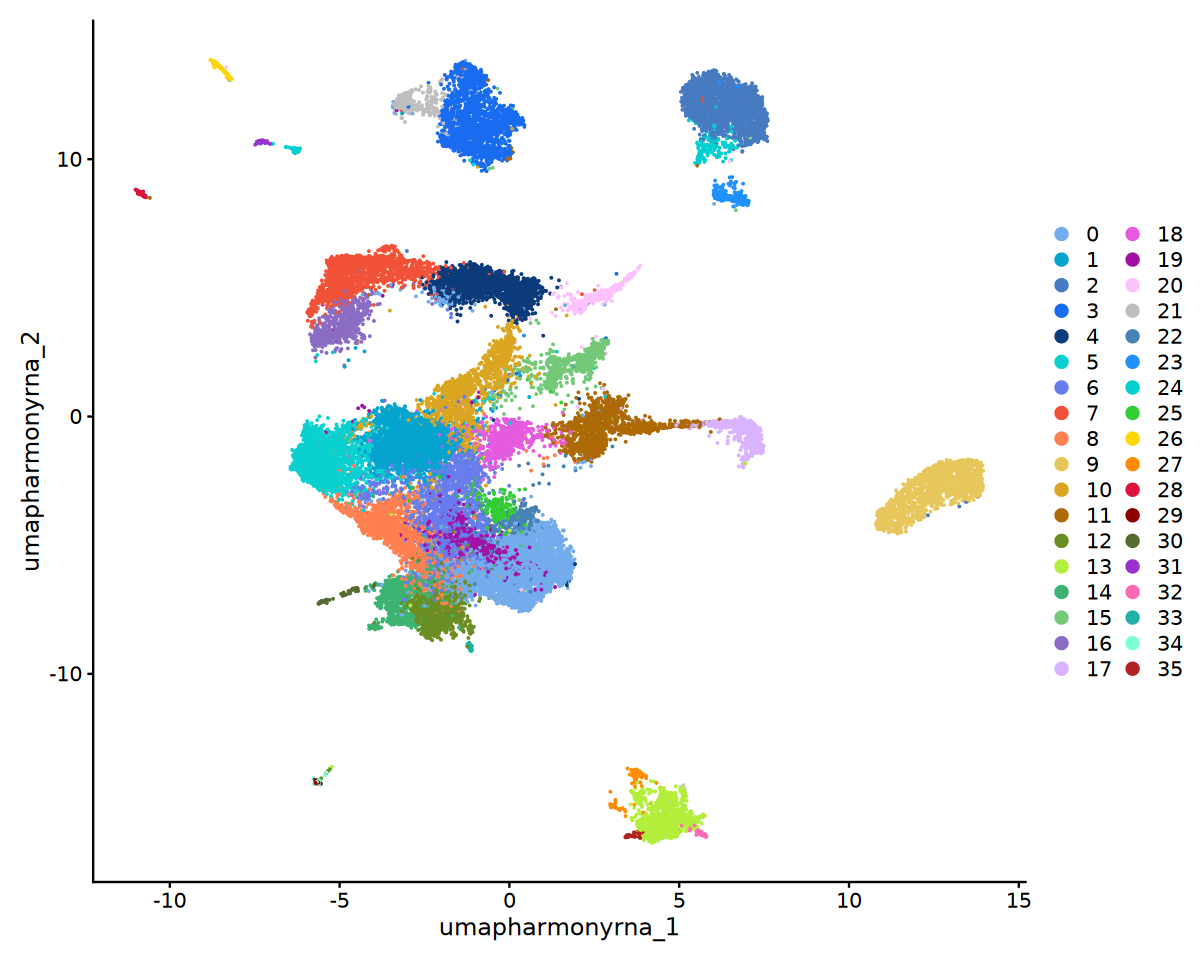

In [21]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(sobj, reduction = "umap.harmony.rna", cols = colors)

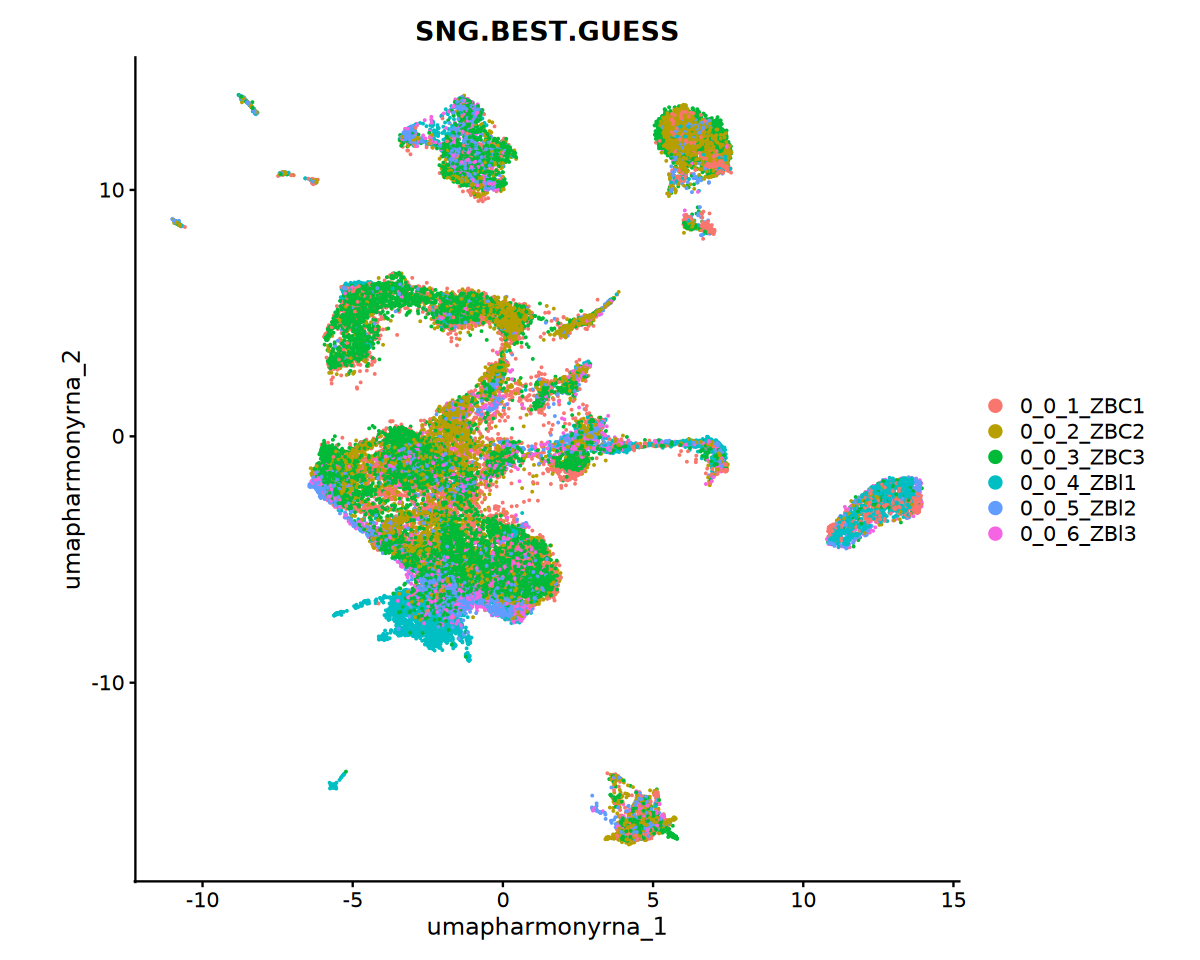

In [22]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(sobj, reduction = "umap.harmony.rna", group.by = "SNG.BEST.GUESS") & theme(aspect.ratio = 1)

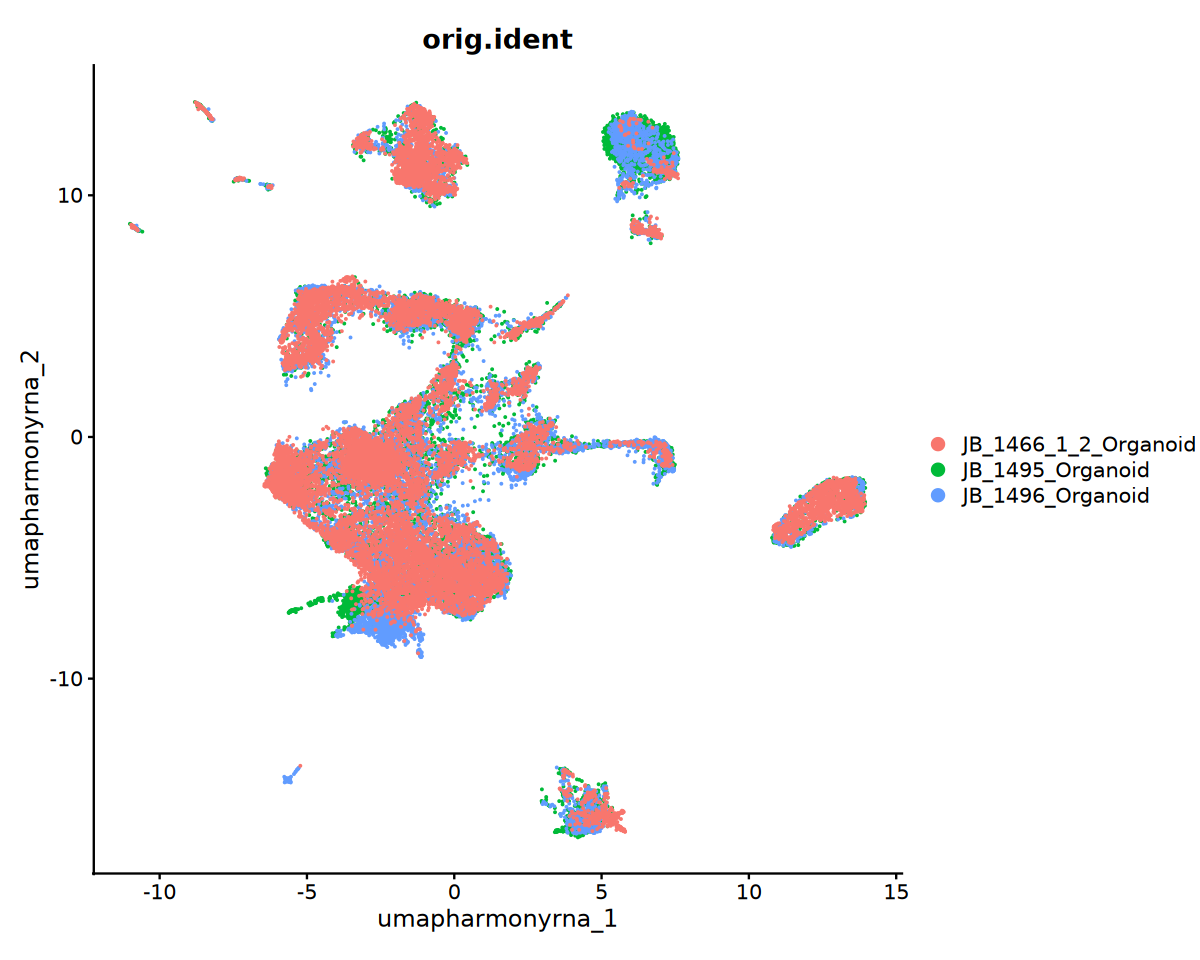

In [23]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(sobj, reduction = "umap.harmony.rna", group.by = "orig.ident") & theme(aspect.ratio = 1)

In [24]:
table(sobj$orig.ident)


JB_1466_1_2_Organoid     JB_1495_Organoid     JB_1496_Organoid 
               14486                10190                10092 

In [25]:
sobj$cond.day  <- case_when(
  grepl("ZBC1", sobj$SNG.BEST.GUESS) ~ "control.day.0",
  grepl("ZBC2", sobj$SNG.BEST.GUESS) ~ "control.day.4",
  grepl("ZBC3", sobj$SNG.BEST.GUESS) ~ "control.day.7",
  grepl("ZBl1", sobj$SNG.BEST.GUESS) ~ "IPF.day.0",
  grepl("ZBl2", sobj$SNG.BEST.GUESS) ~ "IPF.day.7",
  grepl("ZBl3", sobj$SNG.BEST.GUESS) ~ "IPF.day.4",
  TRUE ~ NA_character_ 
  ) # Default case if no match is found

In [26]:
# Assuming sobj is your Seurat object
sobj$Day <- case_when(
  grepl("ZBC1", sobj$SNG.BEST.GUESS) ~ "Day.0",
  grepl("ZBC2", sobj$SNG.BEST.GUESS) ~ "Day.4",
  grepl("ZBC3", sobj$SNG.BEST.GUESS) ~ "Day.7",
  grepl("ZBl1", sobj$SNG.BEST.GUESS) ~ "Day.0",
  grepl("ZBl2", sobj$SNG.BEST.GUESS) ~ "Day.7",
  grepl("ZBl3", sobj$SNG.BEST.GUESS) ~ "Day.4",
  TRUE ~ NA_character_
  )  # Default case if no match is found

In [27]:
sobj$condition  <- case_when(
  grepl("ZBC1", sobj$SNG.BEST.GUESS) ~ "control",
  grepl("ZBC2", sobj$SNG.BEST.GUESS) ~ "control",
  grepl("ZBC3", sobj$SNG.BEST.GUESS) ~ "control",
  grepl("ZBl1", sobj$SNG.BEST.GUESS) ~ "IPF",
  grepl("ZBl2", sobj$SNG.BEST.GUESS) ~ "IPF",
  grepl("ZBl3", sobj$SNG.BEST.GUESS) ~ "IPF",
  TRUE ~ NA_character_  # Default case if no match is found
)

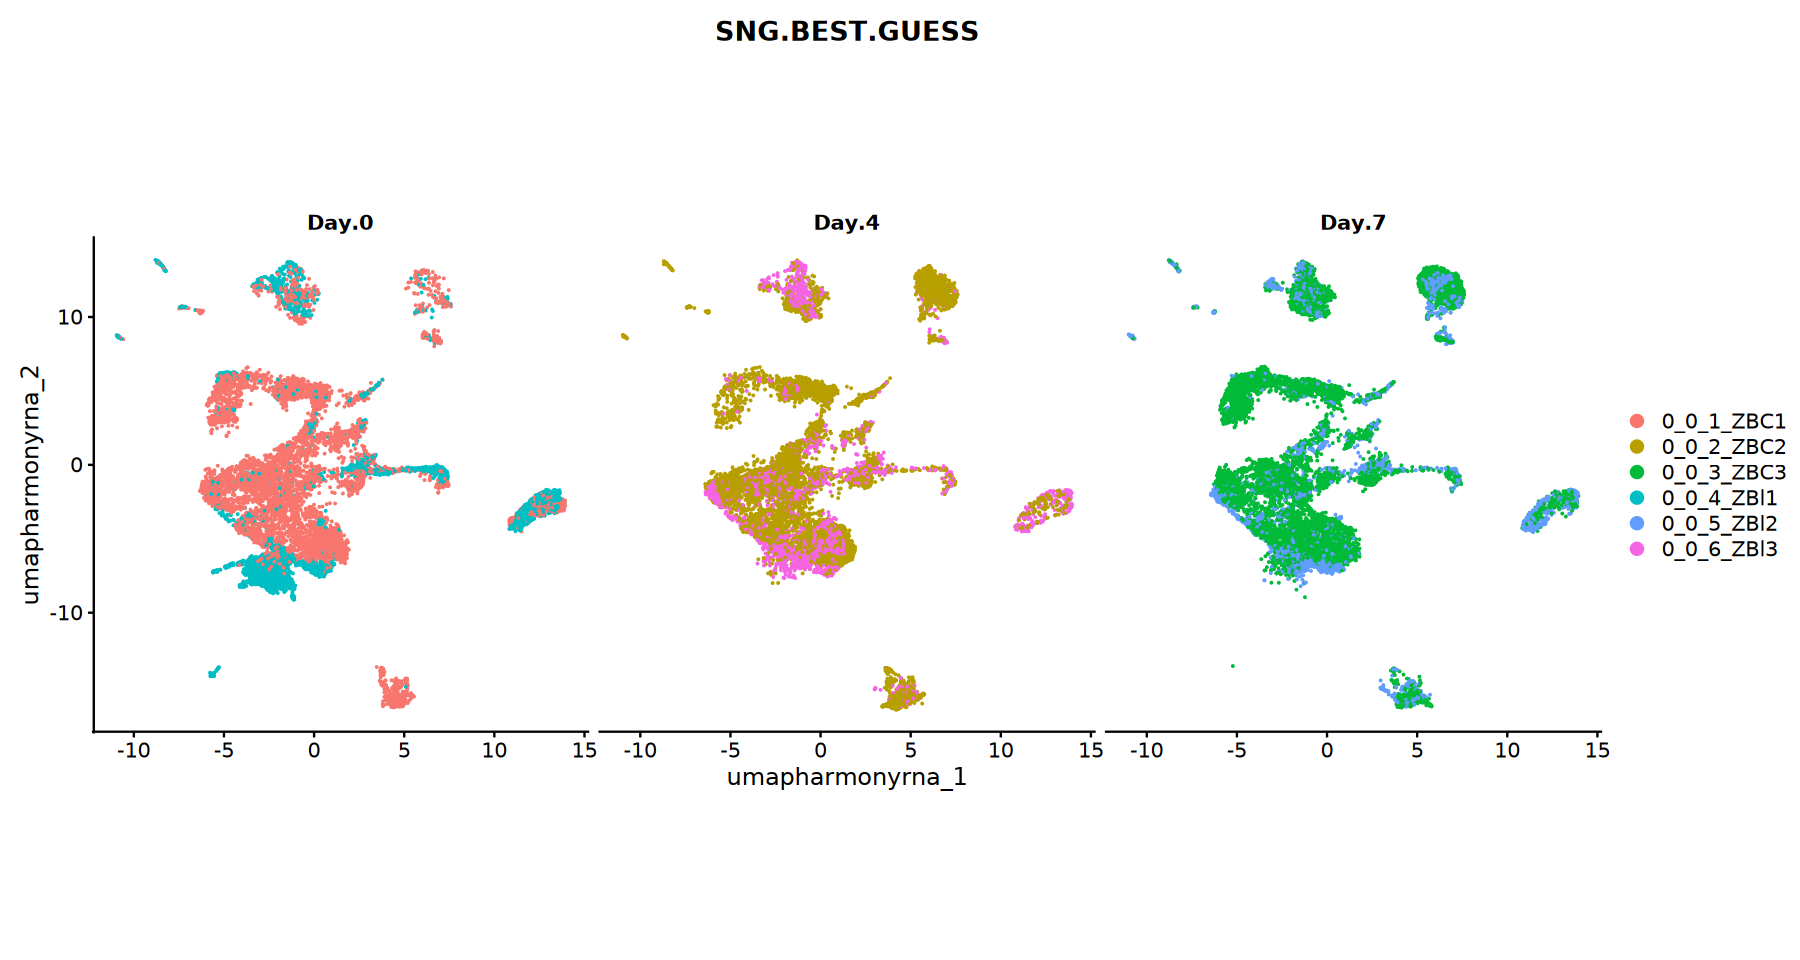

In [28]:
options(repr.plot.width=15, repr.plot.height=8)
DimPlot(sobj, reduction = "umap.harmony.rna", group.by = "SNG.BEST.GUESS", split.by = "Day", ncol = 3) & theme(aspect.ratio = 1)

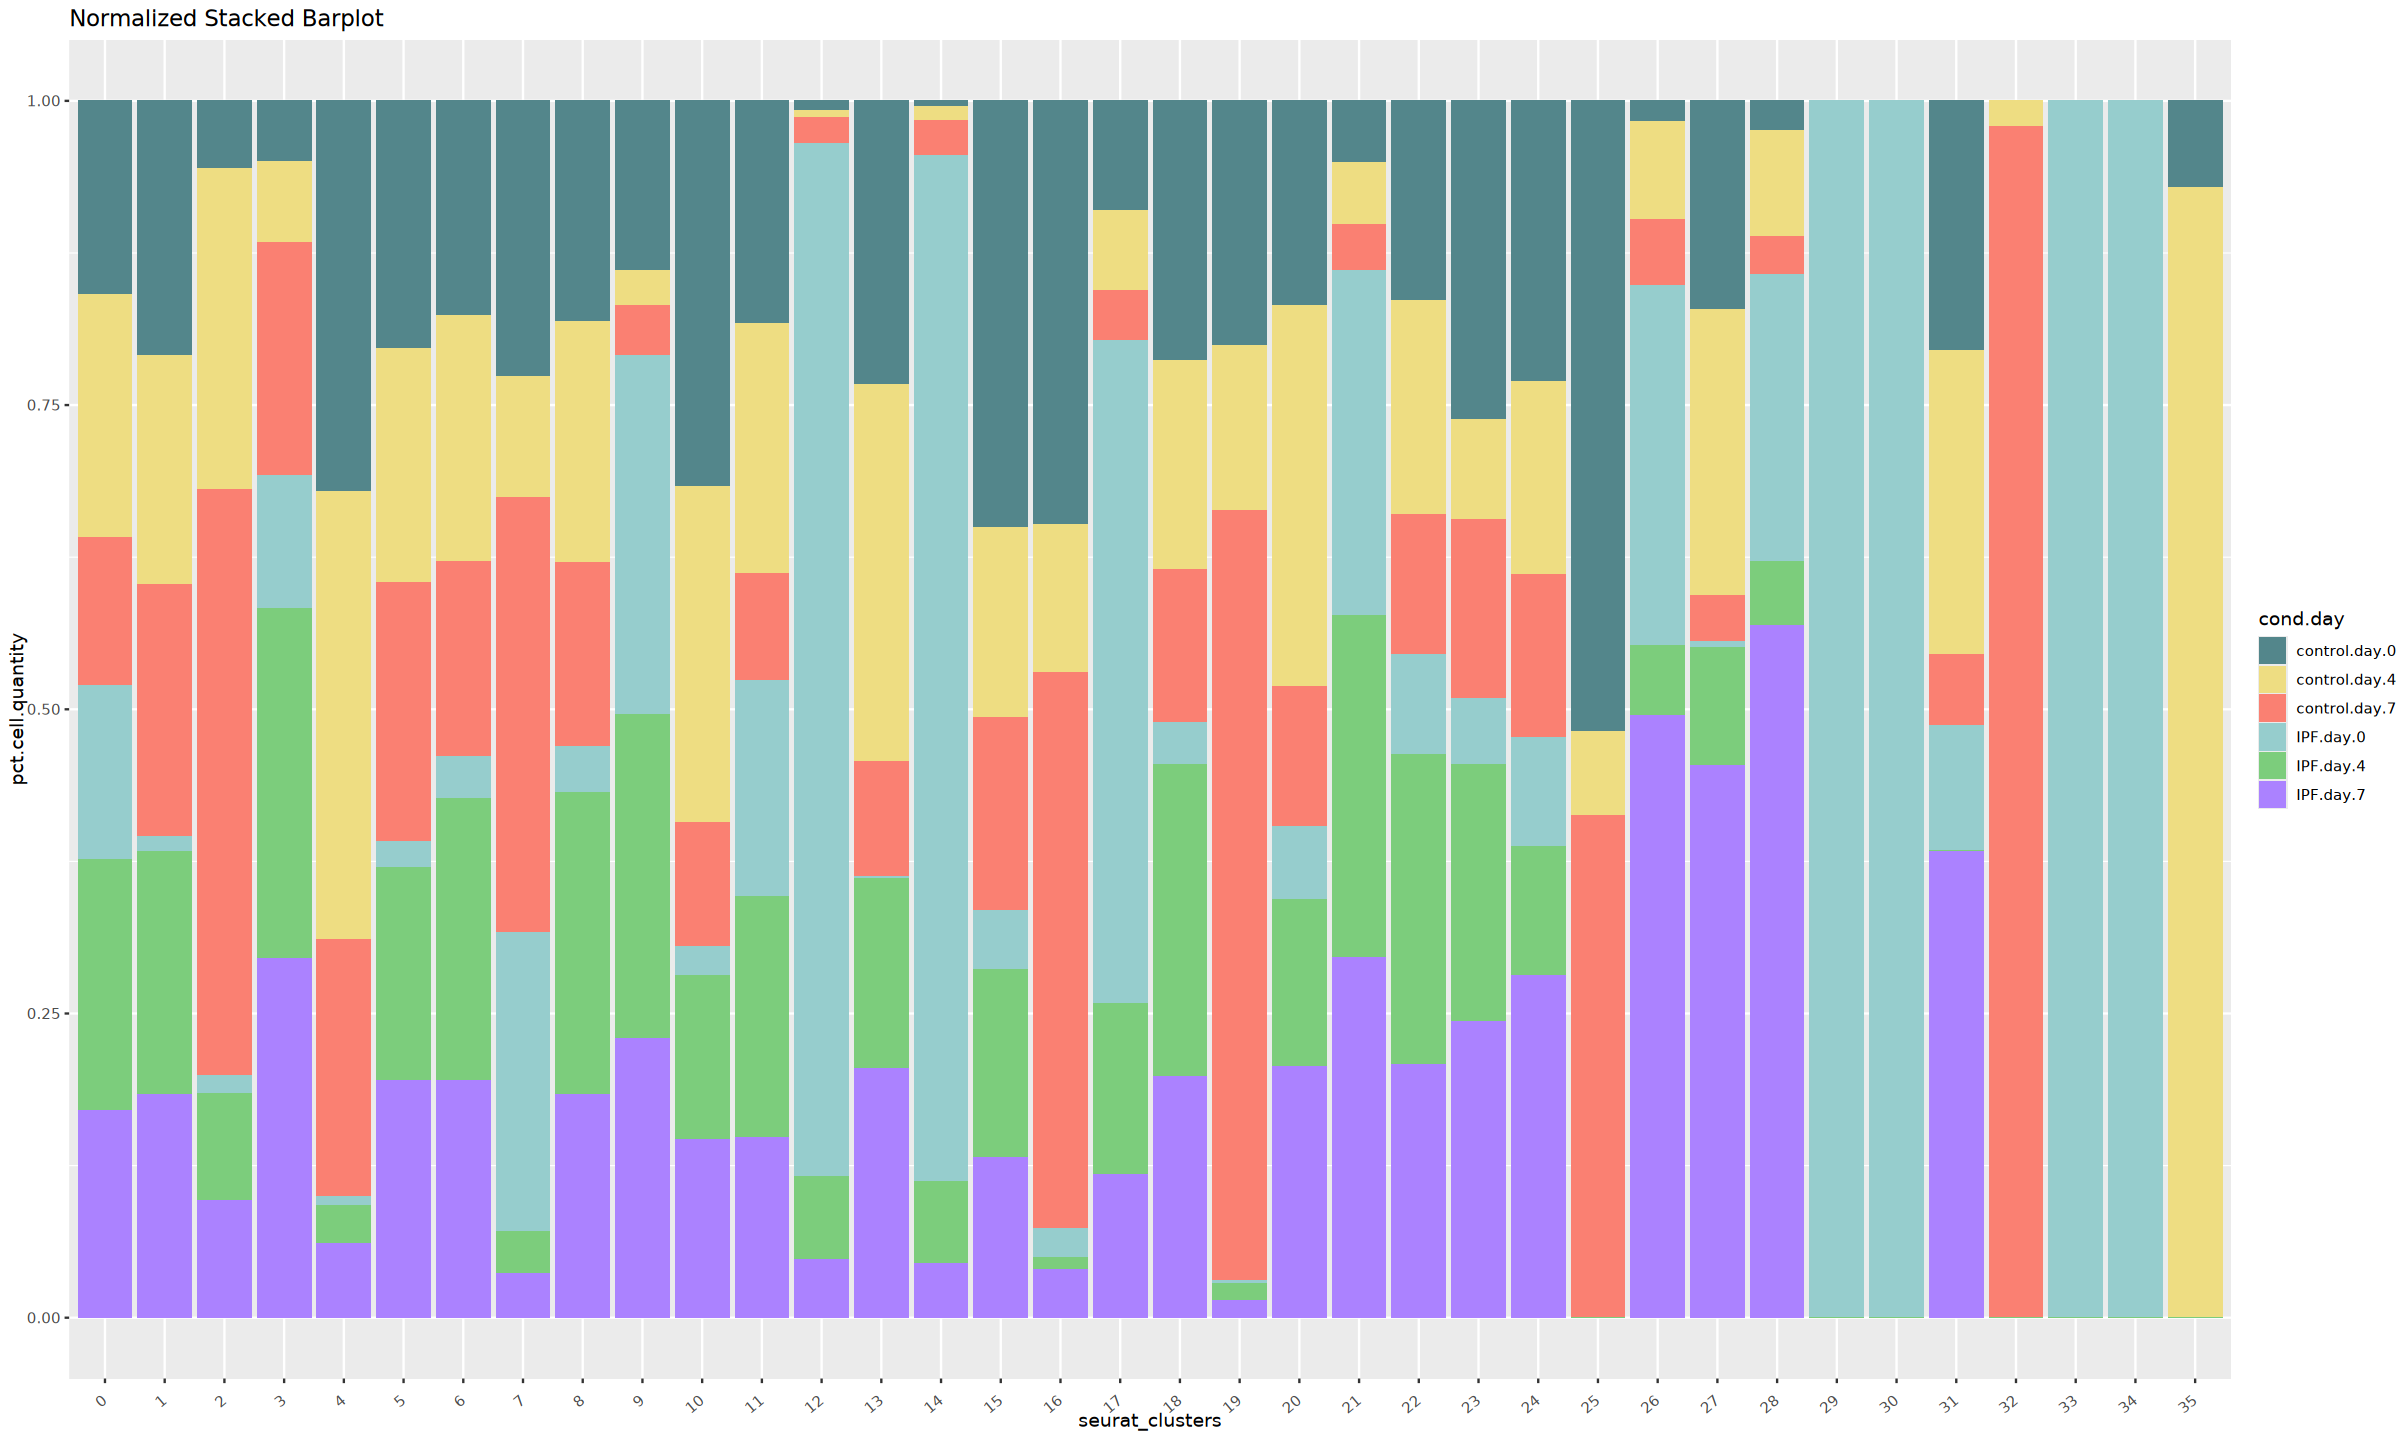

In [29]:
options(repr.plot.width=20, repr.plot.height=12)
norm_cellquant_bplot2.0(sobj, dset.col = "SNG.BEST.GUESS", xlab = "seurat_clusters", stack.by = "cond.day", rand.cols = FALSE)

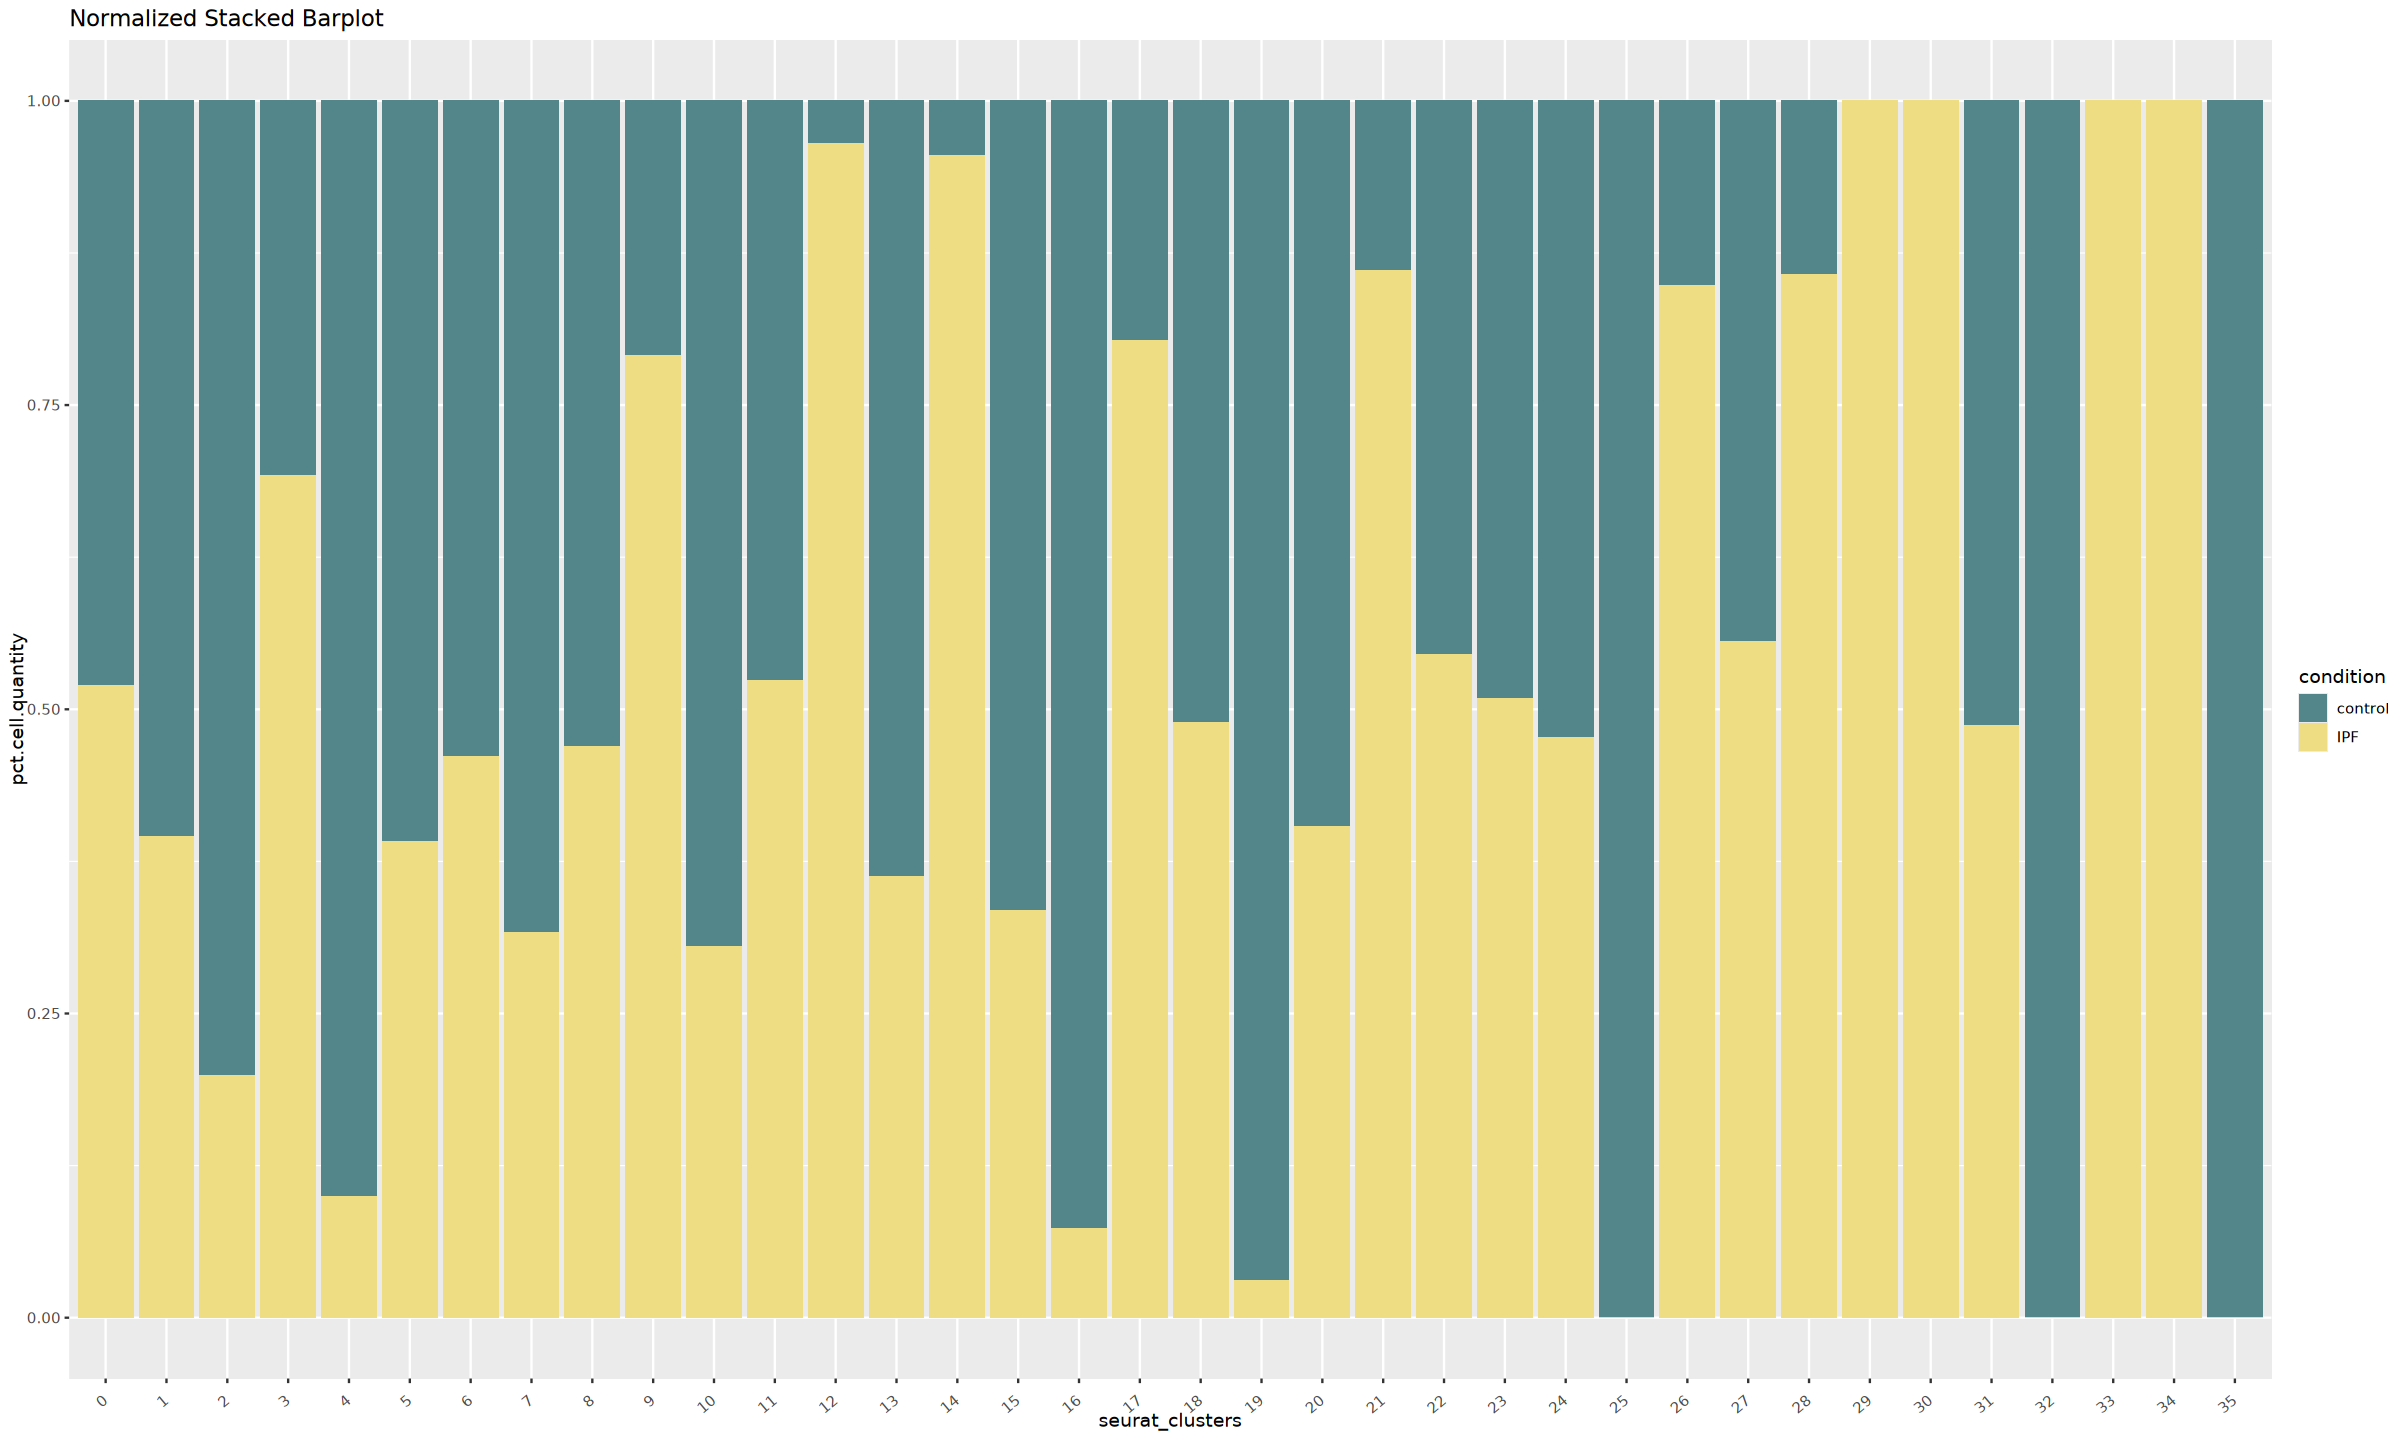

In [30]:
options(repr.plot.width=20, repr.plot.height=12)
norm_cellquant_bplot2.0(sobj, dset.col = "SNG.BEST.GUESS", xlab = "seurat_clusters", stack.by = "condition", rand.cols = FALSE)

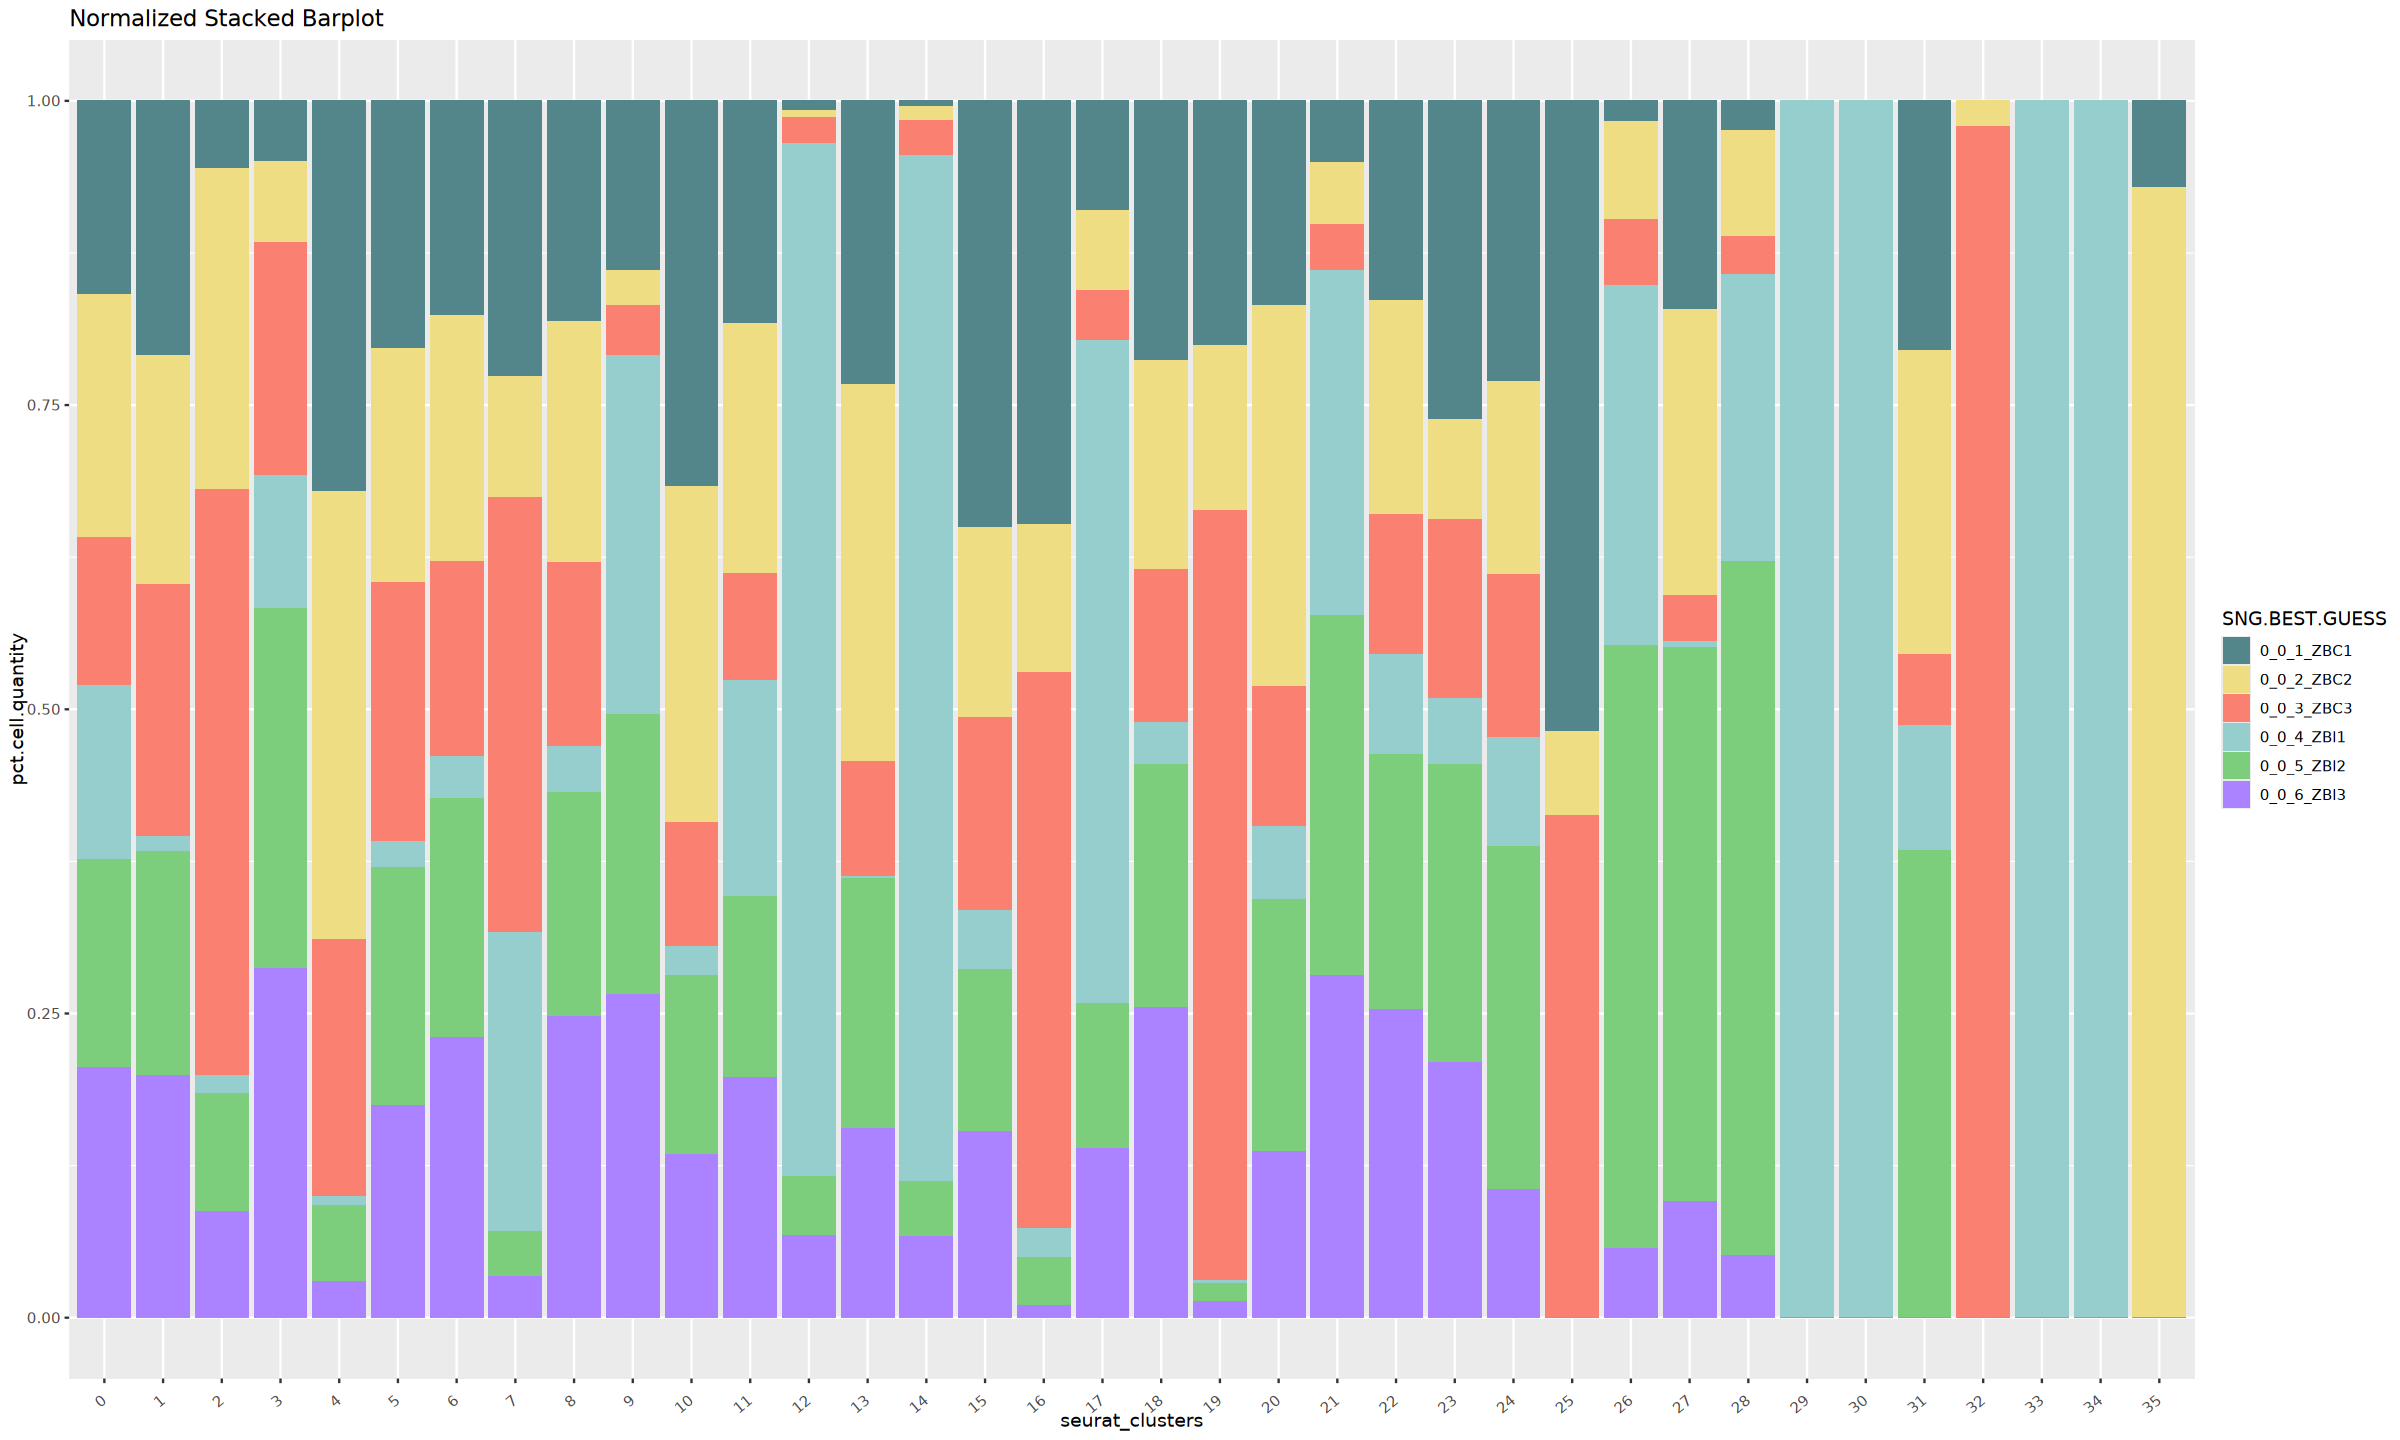

In [31]:
options(repr.plot.width=20, repr.plot.height=12)
norm_cellquant_bplot2.0(sobj, dset.col = "SNG.BEST.GUESS", xlab = "seurat_clusters", stack.by = "SNG.BEST.GUESS", rand.cols = FALSE)

In [32]:
saveRDS(sobj,"250529_lib_donor_batch_SCT_3libs.RDS")